In [33]:
import os
import random
import glob
import gc
import csv
import torch
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from math import floor

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from PIL import Image
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "vscode"

#### Set arguments and random seed

In [91]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
# DEVICE_ID = 2
SEED = 5566


# torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Process data

In [11]:
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 
    4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

def get_train_label_and_image(label_path):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'data/train/{i+7000}.jpg' for i in range(len(train_label))]
    return train_image, train_label

def load_partial_data(train_image_path, train_label):
    train_data = list(zip(train_image_path, train_label))
    data = []
    path = []
    label_list = []
    label_dict = dict()
    for (img_path, label) in train_data:
        label_dict[label] = 0

    for (img_path, label) in train_data:
        if label_dict[label] == 5:
            continue
        else:
            label_dict[label] += 1
            data.append(np.array(Image.open(img_path)))
            label_list.append(label)
            path.append(img_path)

        if sum(label_dict.values()) == 35:
            break

    X_train = np.array(data)
    y_train = np.array(label_list)
    return X_train, y_train, path

def load_train_data(label_path):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'data/train/{i+7000}.jpg' for i in range(len(train_label))]
    train_data = list(zip(train_image, train_label))
    data = []
    label_list = []
    for (path, label) in train_data:
        data.append(np.array(Image.open(path)))
        label_list.append(train_label)
    X_train = np.array(data)
    y_train = np.array(label_list)
    return X_train, y_train

def load_test_data():
    data = []
    test_set = [f'data/test/{i}.jpg' for i in range(7000)]
    for path in test_set:
        data.append(np.array(Image.open(path)))
    X_test = np.array(data)
    return X_test
    
def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

def compute_category_distribution(train_set, emotion_cat):
    emotion = dict()
    for idx, label in emotion_cat.items():
        emotion[label] = 0
    for (img_path, label) in train_set:
        emotion[emotion_cat[label]] += 1
    return emotion

# EDA

In [7]:
train_image_path, train_label = get_train_label_and_image(LABEL_PATH)
X_train_partial, y_train_partial, path = load_partial_data(train_image_path, train_label)
print(X_train_partial.shape)
print(y_train_partial.shape)
#data_partial = np.concatenate([X_train_partial, y_train_partial], axis = 2)

(35, 64, 64)
(35,)


# Data Preprocessing

In [25]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load("y_train.npy")

In [26]:
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tr = transform(X_train)
img_np = np.array(img_tr)
mean_img = np.mean(img_np)
std_img = np.std(img_np)
print(f"Mean of all image is {mean_img}")
print(f"Std of all image is {std_img}")

Mean of all image is 0.5081561803817749
Std of all image is 0.2644411027431488


# Dataset

In [27]:
class FaceExpressionDataset(Dataset):
    def __init__(self, X, y, augment=None):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)
    
    def read_img(self, idx):
        # img = Image.open(self.data[idx][0])
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        # img = torch.from_numpy(img)
        img = img.float()
        #img = self.normalize(img)
        return img
    
    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.y[idx]
        return img, label
    
class TestingDataset(Dataset):
    def __init__(self, X, augment=None):
        self.X = X
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def read_img(self, idx):
        img = self.X[idx]
        if not self.augment is None:
            img = self.augment(img)
        # img = torch.from_numpy(img).float()
        img = img.float()
        #img = self.normalize(img)
        return img
        
    def __getitem__(self, idx):
        img = self.read_img(idx)
        return img

In [74]:
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super(FaceExpressionNet, self).__init__()

        ###########################general information###########################
        self.conv1_out_channels = 64
        self.leakyReLU1_slope = 0.05
        self.conv1_dropout_rate = 0.2

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.Dropout2d(0.2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        #########################location information######################
        self.conv2_out_channels = 512
        self.leakyReLU2_slope = 0.05
        self.conv2_dropout_rate = 0.5
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, self.conv2_out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(self.conv2_out_channels, self.conv2_out_channels, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(self.conv2_out_channels, 7)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 4*4*self.conv2_out_channels)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(64),
            #nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.05),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 4*4*512)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

#### Define training and testing process

In [29]:
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()            
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
        #release memory
        del img, label, output, loss, predict, acc
        torch.cuda.empty_cache()
    #average over all batches
    train_acc = np.mean(train_acc)
    train_loss = np.mean(train_loss)
    return train_acc, train_loss
    
    
def valid(valid_loader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for idx, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc

            #release memory
            del img, label, output, loss, predict, acc
            torch.cuda.empty_cache()
    #average over all batches
    valid_acc = np.mean(valid_acc)
    valid_loss = np.mean(valid_loss)
    gc.collect()
    torch.cuda.empty_cache()
    return valid_acc, valid_loss

def save_checkpoint(model, prefix='model_1110'):
    checkpoint_path = f'{prefix}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    #print('model saved to %s' % checkpoint_path)

In [30]:
#original input dimension: 64 x 64
image_transforms = {'train':transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees = (-20, 20)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                     ]),
            'valid': transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                    ]),
            'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                ])
            }

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train)
train_dataset = FaceExpressionDataset(X_train, y_train, image_transforms["train"])

valid_dataset = FaceExpressionDataset(X_valid, y_valid, image_transforms["valid"])
test_dataset = TestingDataset(X_test, image_transforms["test"])

In [31]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def objective(trial):
    model = FaceExpressionNet()
    model.apply(init_weights)
    model.to(device)
    #summary(model, (1, 64, 64))

    #tunning
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 5*1e-3, 1e-2, log=True)
    batch_size = 256

    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    num_epoch = 500

    #build data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)      

    #record
    acc_record = []
    best_valid_acc = 0
    best_valid_loss = 0
    best_epoch = 0

    no_update_cnt = 0
    patience = 10
    x = time.time()
    for epoch in range(num_epoch):

        train_acc, train_loss = train(train_loader, model, loss_fn, optimizer, device)
        valid_acc, valid_loss = valid(valid_loader, model, loss_fn, device)
        acc_record.append(valid_acc)

        #record
        trial.report(valid_acc, epoch)
        if valid_acc > best_valid_acc:
            model_name = "1111_bh_" + str(batch_size) +"_wd_"+ str(weight_decay) + "_lr_"+ str(lr)
            save_checkpoint(model, prefix=model_name)
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            best_epoch = epoch
            no_update_cnt = 0
        else:
            no_update_cnt += 1
        y = time.time()
        time_train = (y - x) / 60
        print(f"Epoch {epoch}: {round(time_train, 2)} min elapsed, train acc: {round(train_acc * 100, 2)}%, train loss: {round(train_loss, 3)}, valid acc: {round(valid_acc * 100, 2)}%, valid loss: {round(valid_loss, 3)}")
        gc.collect()
        torch.cuda.empty_cache()
        #Early stop
        if no_update_cnt > patience:
            break

    print('########################################################')
    print("Finish model tuning")
    print(f"Best epoch is {best_epoch}, Accuracy: {best_valid_acc}, Loss: {best_valid_loss}")
    print('########################################################')
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned() #不會break for loop
    
    del model, train_loader, valid_loader
    return valid_acc

# Tuning result

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-11-11 07:30:09,172] A new study created in memory with name: no-name-78c11526-2e1e-47dc-9060-22623a1c50ba


Epoch 0: 0.63 min elapsed, train acc: 15.53%, train loss: 3.043, valid acc: 25.21%, valid loss: 1.944
Epoch 1: 1.28 min elapsed, train acc: 16.83%, train loss: 2.772, valid acc: 26.14%, valid loss: 1.895
Epoch 2: 1.93 min elapsed, train acc: 18.36%, train loss: 2.552, valid acc: 26.99%, valid loss: 1.87
Epoch 3: 2.58 min elapsed, train acc: 18.6%, train loss: 2.413, valid acc: 26.92%, valid loss: 1.846
Epoch 4: 3.24 min elapsed, train acc: 18.98%, train loss: 2.307, valid acc: 27.24%, valid loss: 1.84
Epoch 5: 3.88 min elapsed, train acc: 20.53%, train loss: 2.197, valid acc: 27.11%, valid loss: 1.82
Epoch 6: 4.53 min elapsed, train acc: 20.59%, train loss: 2.122, valid acc: 27.89%, valid loss: 1.811
Epoch 7: 5.18 min elapsed, train acc: 20.77%, train loss: 2.07, valid acc: 27.47%, valid loss: 1.807
Epoch 8: 5.83 min elapsed, train acc: 22.07%, train loss: 2.015, valid acc: 27.58%, valid loss: 1.806
Epoch 9: 6.47 min elapsed, train acc: 22.44%, train loss: 1.974, valid acc: 27.33%, val

[I 2021-11-11 07:41:48,066] Trial 0 finished with value: 0.2684851841595126 and parameters: {'weight_decay': 0.0014020948562070731, 'optimizer': 'SGD', 'lr': 0.00635443153140689, 'batch_size': 256}. Best is trial 0 with value: 0.2684851841595126.


Epoch 17: 11.64 min elapsed, train acc: 25.85%, train loss: 1.819, valid acc: 26.85%, valid loss: 1.781
########################################################
Finish model tuning
Best epoch is 6, Accuracy: 0.2788701190805871, Loss: 1.8105578340333084
########################################################
Epoch 0: 0.66 min elapsed, train acc: 19.97%, train loss: 2.675, valid acc: 22.81%, valid loss: 1.824
Epoch 1: 1.31 min elapsed, train acc: 23.24%, train loss: 1.848, valid acc: 24.54%, valid loss: 1.801
Epoch 2: 1.97 min elapsed, train acc: 23.59%, train loss: 1.832, valid acc: 25.39%, valid loss: 1.798
Epoch 3: 2.62 min elapsed, train acc: 23.2%, train loss: 1.828, valid acc: 25.95%, valid loss: 1.799
Epoch 4: 3.3 min elapsed, train acc: 23.39%, train loss: 1.839, valid acc: 25.17%, valid loss: 1.854
Epoch 5: 3.94 min elapsed, train acc: 22.35%, train loss: 1.858, valid acc: 18.18%, valid loss: 1.871
Epoch 6: 4.6 min elapsed, train acc: 21.76%, train loss: 1.883, valid acc: 24.79

[I 2021-11-11 07:51:37,756] Trial 1 finished with value: 0.1679590141235115 and parameters: {'weight_decay': 0.00012086564224560265, 'optimizer': 'Adam', 'lr': 0.06500691200581914, 'batch_size': 256}. Best is trial 0 with value: 0.2684851841595126.


Epoch 14: 9.83 min elapsed, train acc: 20.68%, train loss: 2.072, valid acc: 16.8%, valid loss: 1.848
########################################################
Finish model tuning
Best epoch is 3, Accuracy: 0.25948490722791473, Loss: 1.7990522466856858
########################################################
Epoch 0: 0.66 min elapsed, train acc: 15.93%, train loss: 2.894, valid acc: 23.36%, valid loss: 1.981
Epoch 1: 1.33 min elapsed, train acc: 17.6%, train loss: 2.529, valid acc: 25.92%, valid loss: 1.895
Epoch 2: 1.97 min elapsed, train acc: 18.42%, train loss: 2.293, valid acc: 26.31%, valid loss: 1.847
Epoch 3: 2.63 min elapsed, train acc: 20.03%, train loss: 2.135, valid acc: 26.9%, valid loss: 1.815
Epoch 4: 3.28 min elapsed, train acc: 20.98%, train loss: 2.032, valid acc: 26.61%, valid loss: 1.81
Epoch 5: 3.93 min elapsed, train acc: 21.39%, train loss: 1.975, valid acc: 26.82%, valid loss: 1.799
Epoch 6: 4.6 min elapsed, train acc: 22.84%, train loss: 1.909, valid acc: 27.01%,

[I 2021-11-11 10:40:31,876] Trial 2 finished with value: 0.6251730822486846 and parameters: {'weight_decay': 0.006517502311050756, 'optimizer': 'SGD', 'lr': 0.010656939527848665, 'batch_size': 256}. Best is trial 2 with value: 0.6251730822486846.


Epoch 258: 168.9 min elapsed, train acc: 63.59%, train loss: 0.967, valid acc: 62.52%, valid loss: 0.998
########################################################
Finish model tuning
Best epoch is 247, Accuracy: 0.6265577402381611, Loss: 0.9915532736942686
########################################################
Epoch 0: 0.6 min elapsed, train acc: 15.21%, train loss: 3.117, valid acc: 22.58%, valid loss: 1.9
Epoch 1: 1.21 min elapsed, train acc: 16.51%, train loss: 2.895, valid acc: 26.06%, valid loss: 1.887
Epoch 2: 1.82 min elapsed, train acc: 16.69%, train loss: 2.726, valid acc: 26.14%, valid loss: 1.849
Epoch 3: 2.43 min elapsed, train acc: 17.66%, train loss: 2.58, valid acc: 26.57%, valid loss: 1.848
Epoch 4: 3.04 min elapsed, train acc: 18.1%, train loss: 2.469, valid acc: 26.64%, valid loss: 1.835
Epoch 5: 3.64 min elapsed, train acc: 18.81%, train loss: 2.375, valid acc: 26.83%, valid loss: 1.823
Epoch 6: 4.25 min elapsed, train acc: 19.52%, train loss: 2.285, valid acc: 26.8

[I 2021-11-11 10:52:04,094] Trial 3 finished with value: 0.26253115480476324 and parameters: {'weight_decay': 0.0009768774839394615, 'optimizer': 'SGD', 'lr': 0.008853126071028686, 'batch_size': 512}. Best is trial 2 with value: 0.6251730822486846.


Epoch 18: 11.53 min elapsed, train acc: 23.72%, train loss: 1.887, valid acc: 26.25%, valid loss: 1.783
########################################################
Finish model tuning
Best epoch is 7, Accuracy: 0.27180836333425645, Loss: 1.8148933172225952
########################################################
Epoch 0: 0.65 min elapsed, train acc: 20.74%, train loss: 2.202, valid acc: 23.8%, valid loss: 1.833
Epoch 1: 1.31 min elapsed, train acc: 22.9%, train loss: 1.912, valid acc: 24.37%, valid loss: 1.824
Epoch 2: 1.98 min elapsed, train acc: 24.11%, train loss: 1.879, valid acc: 25.63%, valid loss: 1.83
Epoch 3: 2.63 min elapsed, train acc: 24.76%, train loss: 1.85, valid acc: 26.72%, valid loss: 1.793
Epoch 4: 3.29 min elapsed, train acc: 25.36%, train loss: 1.827, valid acc: 27.17%, valid loss: 1.774
Epoch 5: 3.95 min elapsed, train acc: 26.88%, train loss: 1.789, valid acc: 29.01%, valid loss: 1.734
Epoch 6: 4.61 min elapsed, train acc: 29.18%, train loss: 1.751, valid acc: 32.15

[I 2021-11-11 11:36:36,468] Trial 4 finished with value: 0.5829410135696483 and parameters: {'weight_decay': 1.195310736118879e-05, 'optimizer': 'Adam', 'lr': 0.007320083922109616, 'batch_size': 256}. Best is trial 2 with value: 0.6251730822486846.


Epoch 67: 44.54 min elapsed, train acc: 55.66%, train loss: 1.172, valid acc: 58.29%, valid loss: 1.062
########################################################
Finish model tuning
Best epoch is 56, Accuracy: 0.5981722514538909, Loss: 1.0560615782080025
########################################################
Accuracy: 0.6251730822486846
Best hyperparameters: {'weight_decay': 0.006517502311050756, 'optimizer': 'SGD', 'lr': 0.010656939527848665, 'batch_size': 256}


In [22]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_lr,params_optimizer,params_weight_decay,state
0,0,0.268485,2021-11-11 07:30:09.174955,2021-11-11 07:41:48.066421,0 days 00:11:38.891466,256,0.006354,SGD,0.001402,COMPLETE
1,1,0.167959,2021-11-11 07:41:48.068654,2021-11-11 07:51:37.756529,0 days 00:09:49.687875,256,0.065007,Adam,0.000121,COMPLETE
2,2,0.625173,2021-11-11 07:51:37.757818,2021-11-11 10:40:31.876069,0 days 02:48:54.118251,256,0.010657,SGD,0.006518,COMPLETE
3,3,0.262531,2021-11-11 10:40:31.877832,2021-11-11 10:52:04.093252,0 days 00:11:32.215420,512,0.008853,SGD,0.000977,COMPLETE
4,4,0.582941,2021-11-11 10:52:04.094999,2021-11-11 11:36:36.467795,0 days 00:44:32.372796,256,0.007320,Adam,0.000012,COMPLETE


In [23]:
optuna.visualization.plot_optimization_history(study)

In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_param_importances(study)

In [26]:
optuna.visualization.plot_contour(study, params=['optimizer', 'lr'])

In [28]:
optuna.visualization.plot_contour(study, params=['batch_size', 'weight_decay'])

In [27]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [29]:
optuna.visualization.plot_contour(study, params=['lr', 'weight_decay'])

# Testing

In [15]:
def test(test_loader, model, file_name='./submission/predict_1011.csv'):
    with torch.no_grad():
        predict_result = []
        for idx, img in enumerate(test_loader):
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
        
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

In [16]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test(test_loader, model)

In [17]:
def predict(data_loader, model, device, isValid = False, isTesting = False):
    with torch.no_grad():
        predict_result = []
        if isValid:
            for (img, label) in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
        if isTesting:
            for img in data_loader:
                img = img.to(device)
                output = model(img)
                predict = torch.argmax(output, dim=-1).tolist()
                predict_result += predict
    return predict_result

In [107]:
model = FaceExpressionNet()
model.load_state_dict(torch.load("./submission/model_best.pth"))
model = model.to(device)
batch_size = 128
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
valid_pred = predict(valid_loader, model, device, isValid = True)

In [108]:
correct = sum((valid_pred == valid_label))
print(correct/len(valid_label))

0.561478814732761


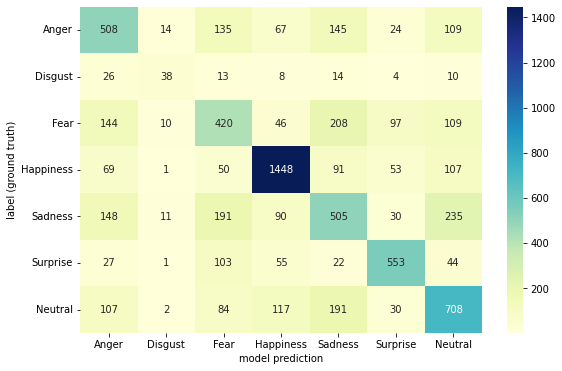

In [102]:
valid_label = np.array(valid_dataset.y)
cf_matrix = confusion_matrix(valid_label, valid_pred)                                
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
emotion_cat = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}                  
class_names = list(emotion_cat.values())

df_cm = pd.DataFrame(cf_matrix, class_names, class_names)     
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("model prediction")
plt.ylabel("label (ground truth)")
plt.savefig("confusion_matrix.png")

In [103]:
def write_to_csv(predict_result, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

In [104]:
model = FaceExpressionNet()
model.load_state_dict(torch.load("./submission/model_best.pth"))
model = model.to(device)
batch_size = 1024
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_pred = predict(test_loader, model, device, isValid = False, isTesting = True)
write_to_csv(test_pred, './submission_1113_3.csv')